# ANÁLISIS EXPLORATORIO DE DATOS

GRUPO 04 - Integrantes:
- Agustin Braida
- Ignacio Carrera
- Matias Etchegoyen
- Agustin Trombetta
- Tomas Ghiglione

# Exploración Inicial

## Carga de datos

Imports

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from sklearn.ensemble import IsolationForest
from google.colab import drive

Leo los datos

In [2]:
drive.mount('/content/drive')

df_oct = pd.read_parquet('/content/drive/MyDrive/datasets_taxis/yellow_tripdata_2024-10.parquet')
df_nov = pd.read_parquet('/content/drive/MyDrive/datasets_taxis/yellow_tripdata_2024-11.parquet')
df_dec = pd.read_parquet('/content/drive/MyDrive/datasets_taxis/yellow_tripdata_2024-12.parquet')
zones = pd.read_csv('/content/drive/MyDrive/datasets_taxis/taxi_zone_lookup.csv')

# Combinar datasets
df = pd.concat([df_oct, df_nov, df_dec], ignore_index=True)
df = df.sample(n=100_000, random_state=42).copy()
df.shape

Mounted at /content/drive


(100000, 19)

Concateno

In [3]:
df = pd.concat([df_oct, df_nov, df_dec], ignore_index=True)
df = df.sample(n=100_000, random_state=42).copy()
df.shape

(100000, 19)

Vista del dataset

In [4]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1674906         1  2024-10-16 17:18:30   2024-10-16 17:47:58              1.0   
4801784         1  2024-11-09 18:53:59   2024-11-09 19:06:11              1.0   
9153960         2  2024-12-14 15:43:00   2024-12-14 15:49:07              1.0   
650435          2  2024-10-07 12:20:46   2024-10-07 12:41:13              2.0   
8835436         1  2024-12-12 11:45:26   2024-12-12 12:05:10              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
1674906           0.70         1.0                  N           186   
4801784           2.80         1.0                  N           141   
9153960           0.69         1.0                  N            43   
650435            7.33         1.0                  N           138   
8835436           2.90         1.0                  N           163   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
1674906           230             1         22.6    5.0      0.5        5.80   
4801784           145             1         13.5    2.5      0.5        5.25   
9153960           142             4          7.9    0.0      0.5        0.00   
650435             75             1         30.3    5.0      0.5        8.75   
8835436            75             1         18.4    2.5      0.5        4.50   

         tolls_amount  improvement_surcharge  total_amount  \
1674906          0.00                    1.0         34.90   
4801784          0.00                    1.0         22.75   
9153960          0.00                    1.0         11.90   
650435           6.94                    1.0         54.24   
8835436          0.00                    1.0         26.90   

         congestion_surcharge  Airport_fee  
1674906                   2.5         0.00  
4801784                   2.5         0.00  
9153960                   2.5         0.00  
650435                    0.0         1.75  
8835436                   2.5         0.00

## Modificaciones para mejor analisis

Creación de columna de duración de viaje

In [5]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

### Mapeo de variables cualitativas

Vendor ID

In [6]:
vendor_labels = {
    1: "Creative Mobile",
    2: "VeriFone"
}
df['VendorID'] = df['VendorID'].map(vendor_labels)

Tipos de tarifa

In [7]:
ratecode_labels = {
    1: "Tarifa estándar",
    2: "JFK",
    3: "Newark",
    4: "Nassau/Westchester",
    5: "Tarifa negociada",
    6: "Viaje grupal"
}
df['RatecodeID'] = df['RatecodeID'].map(ratecode_labels)

Método de pago

In [8]:
payment_labels = {
    1: "Tarjeta",
    2: "Efectivo",
    3: "Sin cargo",
    4: "Disputa",
    5: "Desconocido",
    6: "Anulado"
}
df['payment_type'] = df['payment_type'].map(payment_labels)

### Tipos de datos y cantidad de nulos por columna

In [9]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 1674906 to 8272376
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               99988 non-null   object        
 1   tpep_pickup_datetime   100000 non-null  datetime64[us]
 2   tpep_dropoff_datetime  100000 non-null  datetime64[us]
 3   passenger_count        90201 non-null   float64       
 4   trip_distance          100000 non-null  float64       
 5   RatecodeID             89041 non-null   object        
 6   store_and_fwd_flag     90201 non-null   object        
 7   PULocationID           100000 non-null  int32         
 8   DOLocationID           100000 non-null  int32         
 9   payment_type           90201 non-null   object        
 10  fare_amount            100000 non-null  float64       
 11  extra                  100000 non-null  float64       
 12  mta_tax                100000 non-null  fl

VendorID                    12
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count           9799
trip_distance                0
RatecodeID               10959
store_and_fwd_flag        9799
PULocationID                 0
DOLocationID                 0
payment_type              9799
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge      9799
Airport_fee               9799
trip_duration                0
dtype: int64

## Analisis de variables cuantitativas

Filtramos columnas numéricas

In [10]:
numeric_cols = df.select_dtypes(include='number').columns

Calculamos estadísticas y uso la traspuesta para mejor visualización

In [11]:
df[numeric_cols].describe().T

count        mean         std         min     25%  \
passenger_count         90201.0    1.332069    0.787165    0.000000    1.00   
trip_distance          100000.0    5.531341  359.008799    0.000000    1.00   
PULocationID           100000.0  164.799130   64.322380    1.000000  132.00   
DOLocationID           100000.0  164.247210   69.449180    1.000000  114.00   
fare_amount            100000.0   19.535804   19.099257 -200.000000    9.30   
extra                  100000.0    1.359025    1.801347   -7.500000    0.00   
mta_tax                100000.0    0.476620    0.139816   -0.500000    0.50   
tip_amount             100000.0    3.404564    4.086078   -5.000000    0.00   
tolls_amount           100000.0    0.554447    2.167471  -27.380000    0.00   
improvement_surcharge  100000.0    0.953967    0.280706   -1.000000    1.00   
total_amount           100000.0   28.145943   23.989712 -203.500000   15.96   
congestion_surcharge    90201.0    2.227442    0.900152   -2.500000    2.50   
Airport_fee             90201.0    0.138097    0.490714   -1.750000    0.00   
trip_duration          100000.0   18.373467   36.239992  -49.316667    8.15   

                              50%     75%           max  
passenger_count          1.000000    1.00      6.000000  
trip_distance            1.720000    3.32  68623.060000  
PULocationID           162.000000  234.00    265.000000  
DOLocationID           162.000000  234.00    265.000000  
fare_amount             14.200000   23.30    439.800000  
extra                    1.000000    2.50     11.750000  
mta_tax                  0.500000    0.50      1.000000  
tip_amount               2.660000    4.40     90.000000  
tolls_amount             0.000000    0.00     37.260000  
improvement_surcharge    1.000000    1.00      1.000000  
total_amount            21.400000   31.44    452.670000  
congestion_surcharge     2.500000    2.50      2.500000  
Airport_fee              0.000000    0.00      1.750000  
trip_duration           13.716667   22.50   4835.716667

Calculamos las modas

In [12]:
modas = {}
total = len(df)

for col in df:
    moda = df[col].mode().iloc[0]
    cantidad = (df[col] == moda).sum()
    porcentaje = round(100 * cantidad / total, 2)
    modas[col] = (moda, cantidad, porcentaje)

modas_df = pd.DataFrame.from_dict(modas, orient='index', columns=['Moda', 'Cantidad', 'Porcentaje (%)'])
modas_df

Moda  Cantidad  Porcentaje (%)
VendorID                          VeriFone     77036           77.04
tpep_pickup_datetime   2024-10-11 17:42:06         3            0.00
tpep_dropoff_datetime  2024-10-08 08:58:34         3            0.00
passenger_count                        1.0     69367           69.37
trip_distance                          0.0      1934            1.93
RatecodeID                 Tarifa estándar     84279           84.28
store_and_fwd_flag                       N     89801           89.80
PULocationID                           237      5160            5.16
DOLocationID                           236      4567            4.57
payment_type                       Tarjeta     74533           74.53
fare_amount                            8.6      3932            3.93
extra                                  0.0     46011           46.01
mta_tax                                0.5     97002           97.00
tip_amount                             0.0     28094           28.09
tolls_amount                           0.0     92351           92.35
improvement_surcharge                  1.0     97139           97.14
total_amount                          16.8      1263            1.26
congestion_surcharge                   2.5     81833           81.83
Airport_fee                            0.0     82547           82.55
trip_duration                          9.0       116            0.12

## Analisis de variables cualitativas

Filtramos las columnas que contienen texto o categorías

In [13]:
categorical_cols = df.select_dtypes(include='object').columns

Para cada variable categórica, mostramos su cantidad de valores únicos y las frecuencias más comunes

In [14]:
for col in categorical_cols:
    print(f"\nColumna: {col}")
    print("Valores únicos:", df[col].nunique())
    print(df[col].value_counts().head(10))


Columna: VendorID
Valores únicos: 2
VendorID
VeriFone           77036
Creative Mobile    22952
Name: count, dtype: int64

Columna: RatecodeID
Valores únicos: 5
RatecodeID
Tarifa estándar       84279
JFK                    3348
Tarifa negociada        855
Newark                  303
Nassau/Westchester      256
Name: count, dtype: int64

Columna: store_and_fwd_flag
Valores únicos: 2
store_and_fwd_flag
N    89801
Y      400
Name: count, dtype: int64

Columna: payment_type
Valores únicos: 4
payment_type
Tarjeta      74533
Efectivo     12777
Disputa       2156
Sin cargo      735
Name: count, dtype: int64


## Visualizacion de distribuciones

Proveedores

In [15]:
px.pie(df, names='VendorID', title='Proveedores de registro')

Cantidad de pasajeros

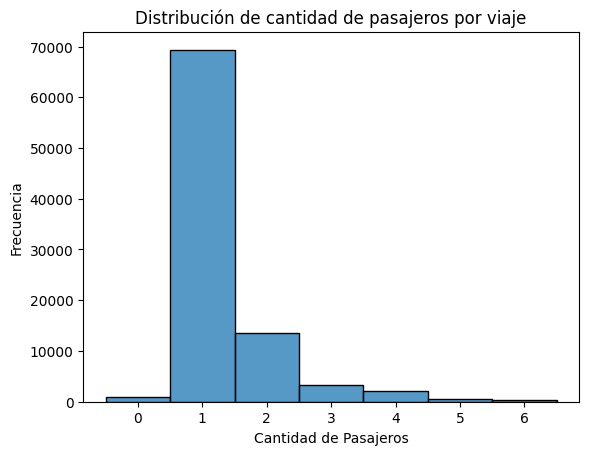

In [16]:
sns.histplot(df['passenger_count'], discrete=True).set(
    title="Distribución de cantidad de pasajeros por viaje",
    xlabel="Cantidad de Pasajeros",
    ylabel="Frecuencia",
    xticks=[0, 1, 2, 3, 4, 5, 6],
);

Duración de viajes

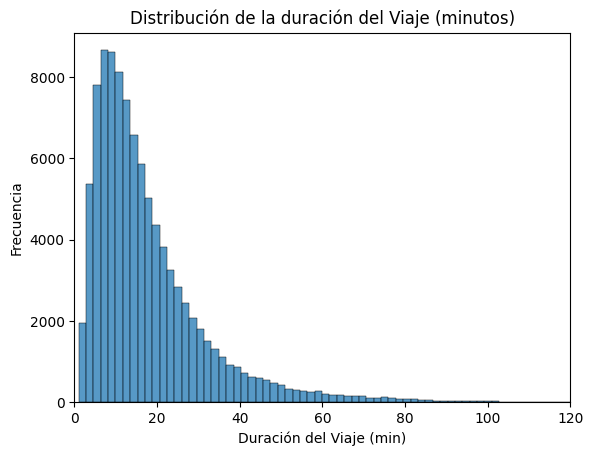

In [17]:
filtered = df[df['trip_duration'].between(1, 180)]

sns.histplot(filtered['trip_duration'],bins=100).set(
    title="Distribución de la duración del Viaje (minutos)",
    xlabel="Duración del Viaje (min)",
    ylabel="Frecuencia",
    xlim=(0, 120)
);

Tarifas

In [18]:
px.pie(df, names='RatecodeID', title='Tipos de tarifa')

Monto total

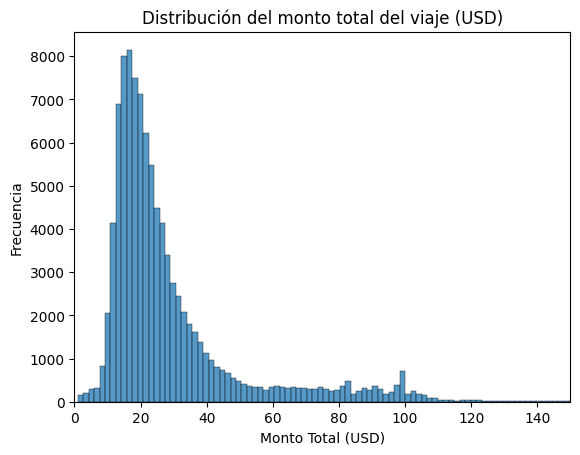

In [19]:
filtered = df[df['total_amount'].between(1, 200)]

sns.histplot(filtered['total_amount'], bins=120).set(
    title="Distribución del monto total del viaje (USD)",
    xlabel="Monto Total (USD)",
    ylabel="Frecuencia",
    xlim=(0, 150)
);

Formas de pago

In [20]:
px.pie(df, names='payment_type', title='Formas de Pago')

Propinas

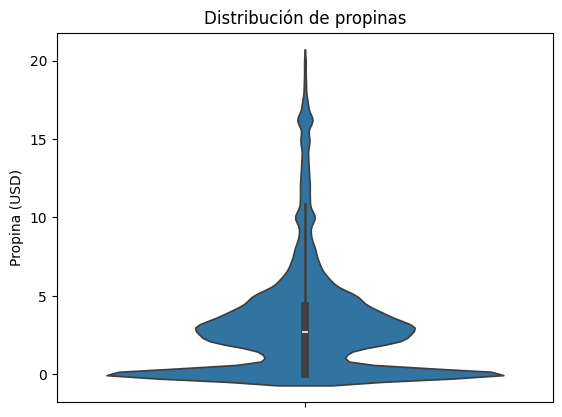

In [21]:
filtered = df[df['tip_amount'].between(0, 20)]

sns.violinplot(y=filtered['tip_amount']).set(
    title="Distribución de propinas",
    ylabel="Propina (USD)"
);

## Analisis de correlacion

Generamos la matriz

In [22]:
matriz = df[numeric_cols].corr().abs()

Ponemos la diagonal en blanco para mejor visualización

In [23]:
mask = np.eye(len(matriz), dtype=bool)
matriz.values[mask] = np.nan

Mostramos el resultado

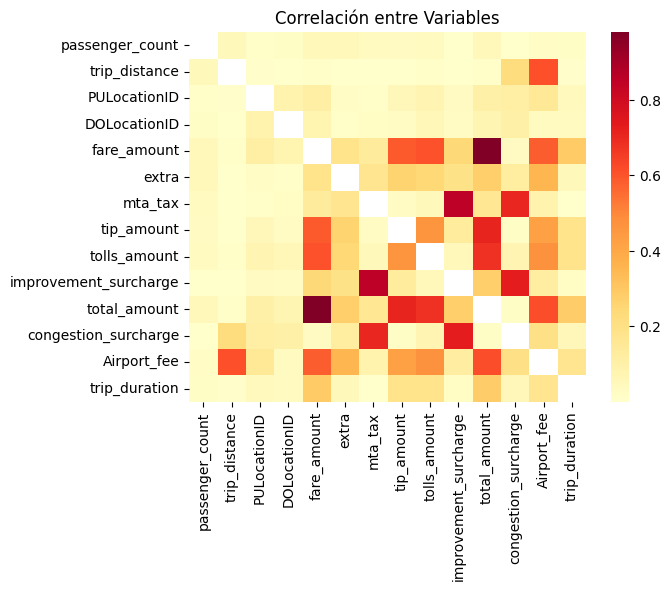

In [24]:
sns.heatmap(matriz, annot=False, cmap="YlOrRd").set(
    title="Correlación entre Variables"
);

# Datos Faltantes

## Porcentaje de datos faltantes por columna

In [25]:
porcentaje_faltante = df.isnull().mean().sort_values(ascending=False) * 100
porcentaje_faltante = porcentaje_faltante[porcentaje_faltante > 0].round(2)

faltante_df = porcentaje_faltante.reset_index()
faltante_df.columns = ['Variable', 'Porcentaje de datos faltantes']
faltante_df

Variable  Porcentaje de datos faltantes
0            RatecodeID                          10.96
1       passenger_count                           9.80
2    store_and_fwd_flag                           9.80
3          payment_type                           9.80
4  congestion_surcharge                           9.80
5           Airport_fee                           9.80
6              VendorID                           0.01

## Visualización de datos faltantes

In [26]:
fig = px.bar(
    faltante_df,
    x='Porcentaje de datos faltantes',
    y='Variable',
    orientation='h',
    title='Porcentaje de datos faltantes por variable',
    text='Porcentaje de datos faltantes',
)
fig.update_layout(yaxis=dict(categoryorder='total ascending'))
fig.show()

## Datos faltantes por registro

Agreamos columna para calcular los campos faltante por registro

In [27]:
df['porcentaje_de_faltantes'] = df.isnull().mean(axis=1).round(4) * 100

Los separamos segun cuanto les falta

In [28]:
todos_los_datos = (df['porcentaje_de_faltantes'] == 0).sum()
faltantes_menores_10 = ((df['porcentaje_de_faltantes'] > 0) & (df['porcentaje_de_faltantes'] <= 10)).sum()
faltantes_mayores_10 = (df['porcentaje_de_faltantes'] > 10).sum()

print(f"{todos_los_datos:,} registros tienen todos los datos completos.")
print(f"{faltantes_menores_10:,} registros tienen 10% o menos de datos faltantes.")
print(f"{faltantes_mayores_10:,} registros tienen más del 10% de datos faltantes.")

89,037 registros tienen todos los datos completos.
1,164 registros tienen 10% o menos de datos faltantes.
9,799 registros tienen más del 10% de datos faltantes.


## Manejo de valores faltantes

Vemos las modas para analizar como completar

In [29]:
modas_df

Moda  Cantidad  Porcentaje (%)
VendorID                          VeriFone     77036           77.04
tpep_pickup_datetime   2024-10-11 17:42:06         3            0.00
tpep_dropoff_datetime  2024-10-08 08:58:34         3            0.00
passenger_count                        1.0     69367           69.37
trip_distance                          0.0      1934            1.93
RatecodeID                 Tarifa estándar     84279           84.28
store_and_fwd_flag                       N     89801           89.80
PULocationID                           237      5160            5.16
DOLocationID                           236      4567            4.57
payment_type                       Tarjeta     74533           74.53
fare_amount                            8.6      3932            3.93
extra                                  0.0     46011           46.01
mta_tax                                0.5     97002           97.00
tip_amount                             0.0     28094           28.09
tolls_amount                           0.0     92351           92.35
improvement_surcharge                  1.0     97139           97.14
total_amount                          16.8      1263            1.26
congestion_surcharge                   2.5     81833           81.83
Airport_fee                            0.0     82547           82.55
trip_duration                          9.0       116            0.12

Elegimos no borrar valores ya que a los registros que les falta algun campo, son los mismos que le falta el resto de los campos. Podria borrarlos pero representan un ~10% de la totalidad, entonces aprovecho que las modas tienen valores porcentuales muy altos respecto de la totalidad (> 80%) para completar y no perder tantos registros.

In [30]:
df['RatecodeID'].fillna('Tarifa estándar', inplace=True)
df['Airport_fee'].fillna(0, inplace=True)
df['congestion_surcharge'].fillna(0, inplace=True)
df['store_and_fwd_flag'].fillna('N', inplace=True)
df['passenger_count'].fillna(1.0, inplace=True)
df['VendorID'].fillna('VeriFone', inplace=True)

<ipython-input-30-744651882b74>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-30-744651882b74>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

En payment_type la moda es significativa pero no tanto como en el resto, entonces lo completamos de manera proporcional

In [31]:
distribucion = df['payment_type'].value_counts(normalize=True)
faltantes = df['payment_type'].isnull()

df.loc[faltantes, 'payment_type'] = np.random.choice(
    distribucion.index,
    size=faltantes.sum(),
    p=distribucion.values
)

## Valores mal ingresados

Los que si vamos a eliminar son los viajes con distancia, duracion o costo igual o menor cero, podrian ser viajes cancelados o algun error en la carga, pero si vamos a hacer un estudio de los viajes, tiene mayor sentido estudiar los que se llevaron a cabo

In [32]:
df = df[(df['trip_distance'] > 0) & (df['trip_duration'] > 0) & (df['total_amount'] >= 0)]

# Outliers

Para poder lograr una buena visualización, primero eliminamos registros que son outliers que evidentemente representan errores de carga ya que no tienen ningun sentido real

In [33]:
df = df[(df['trip_distance'] <= 200) & (df['trip_duration'] <= 1000) & (df['total_amount'] <= 1000)]

## Deteccion univariada

Le agregamos a la función teórica unos límites extra con factores muy altos que nos permitan identificar outliers muy extremos, que a pesar de que si podrían ser casos reales, se alejan demasiado de la media. Esto para luego poder descartar esos, y no descartar los severos, que son severos únicamente por su lejanía con la media y no por ser valores "sin sentido".

In [34]:
def detectar_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    li_mod = Q1 - 1.5 * IQR
    ls_mod = Q3 + 1.5 * IQR
    li_sev = Q1 - 3 * IQR
    ls_sev = Q3 + 3 * IQR
    li_ext = Q1 - 15 * IQR # Para detectar outliers muy extremos debido al alto volumen de datos
    ls_ext = Q3 + 15 * IQR

    outliers_moderados = df[(df[col] < li_mod) | (df[col] > ls_mod)] #borrar
    outliers_severos = df[(df[col] < li_sev) | (df[col] > ls_sev)] #borrar

    return {
        'moderados': outliers_moderados, #borrar
        'severos': outliers_severos, #borrar
        'limites': {
            'mod_inf': li_mod,
            'mod_sup': ls_mod,
            'sev_inf': li_sev,
            'sev_sup': ls_sev,
            'ext_inf': li_ext,
            'ext_sup': ls_ext,
        }
    }

Outliers en la distancia

In [35]:
resultado_dist = detectar_outliers_iqr(df, 'trip_distance')
limites_dist = resultado_dist['limites']

Visualizamos

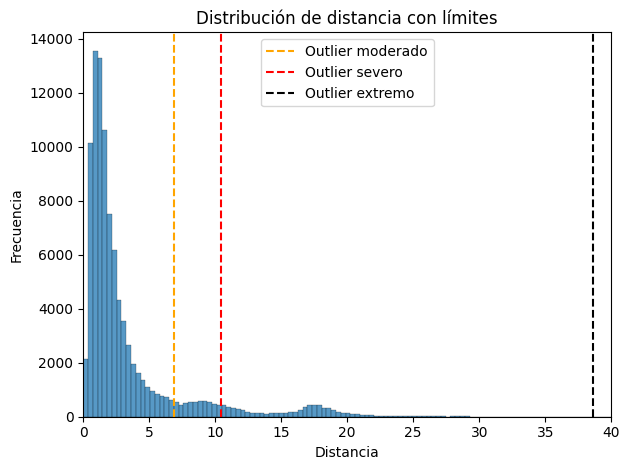

In [36]:
sns.histplot(df['trip_distance'], bins=200)
plt.axvline(limites_dist['mod_sup'], color='orange', linestyle='--', label='Outlier moderado')
plt.axvline(limites_dist['sev_sup'], color='red', linestyle='--', label='Outlier severo')
plt.axvline(limites_dist['ext_sup'], color='black', linestyle='--', label='Outlier extremo')
plt.xlim(0, 40)
plt.title("Distribución de distancia con límites")
plt.xlabel("Distancia")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

Outliers de duración

In [37]:
resultado_dur = detectar_outliers_iqr(df, 'trip_duration')
limites_dur = resultado_dur['limites']

Visualizamos

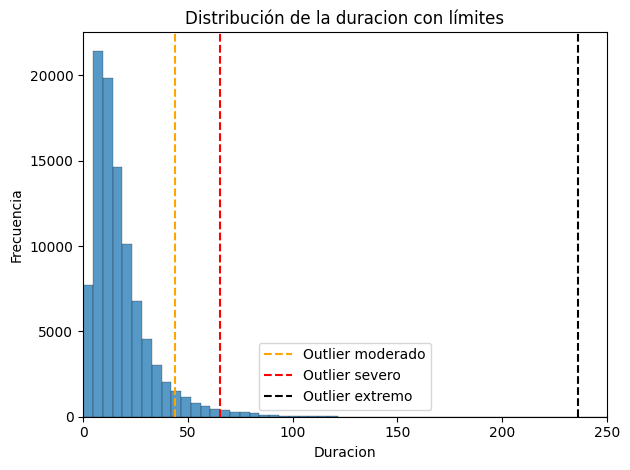

In [38]:
sns.histplot(df['trip_duration'], bins=200)
plt.axvline(limites_dur['mod_sup'], color='orange', linestyle='--', label='Outlier moderado')
plt.axvline(limites_dur['sev_sup'], color='red', linestyle='--', label='Outlier severo')
plt.axvline(limites_dur['ext_sup'], color='black', linestyle='--', label='Outlier extremo')
plt.xlim(0, 250)
plt.title("Distribución de la duracion con límites")
plt.xlabel("Duracion")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

Outliers de costo total

In [39]:
resultado_amo = detectar_outliers_iqr(df, 'total_amount')
limites_amo = resultado_amo['limites']

Visualizamos

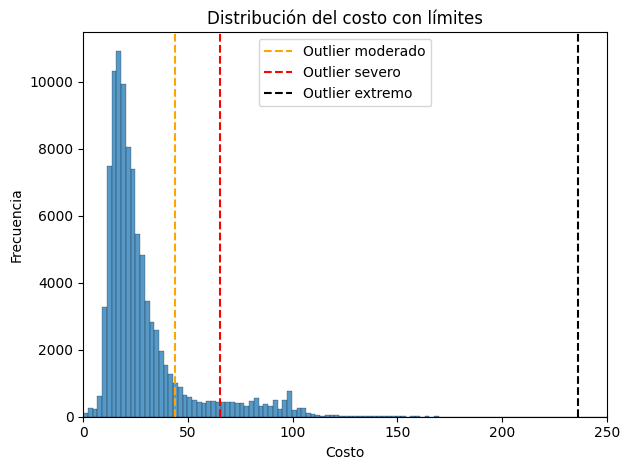

In [40]:
sns.histplot(df['total_amount'], bins=200)
plt.axvline(limites_dur['mod_sup'], color='orange', linestyle='--', label='Outlier moderado')
plt.axvline(limites_dur['sev_sup'], color='red', linestyle='--', label='Outlier severo')
plt.axvline(limites_dur['ext_sup'], color='black', linestyle='--', label='Outlier extremo')
plt.xlim(0, 250)
plt.title("Distribución del costo con límites")
plt.xlabel("Costo")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

Los outliers moderados y los severos los vamos a conservar, ya que son estiadisticamente valores atipicos unicamente por lo alejados que estan de la media dentro de esta cantidad enorme de datos. Pero los extremos vamos a eliminarlos, alguno que otro podria llegar a ser algo con sentido, pero en general esos valores deberian ser errores de carga.

In [41]:
inf = limites_dist['ext_inf']
sup = limites_dist['ext_sup']

df = df[(df['trip_distance'] >= inf) & (df['trip_distance'] <= sup)]

In [42]:
inf = limites_dur['ext_inf']
sup = limites_dur['ext_sup']

df = df[(df['trip_duration'] >= inf) & (df['trip_duration'] <= sup)]

In [43]:
inf = limites_amo['ext_inf']
sup = limites_amo['ext_sup']

df = df[(df['total_amount'] >= inf) & (df['total_amount'] <= sup)]

## Detección Multivariada

Analizamos las 3 variables mas principales, distancia, tiempo y costo

In [44]:
X = df[['trip_distance', 'trip_duration', 'total_amount']]

Normalizamos las columnas

In [45]:
X_scaled = StandardScaler().fit_transform(X)

Calculamos la distancia de Mahalanobis

In [46]:
cov = np.cov(X_scaled.T)
inv_cov = inv(cov)
mean = np.mean(X_scaled, axis=0)

d_mahal = np.array([mahalanobis(x, mean, inv_cov) for x in X_scaled])
df['mahal_dist'] = d_mahal

Definimos umbral y marcamos outliers

In [47]:
umbral = np.percentile(df['mahal_dist'], 99)
df['mahal_outlier'] = df['mahal_dist'] > umbral

Consideramos outliers al 1% más extremo multivariadamente

In [48]:
fig = px.scatter_3d(
    df,
    x='trip_distance',
    y='trip_duration',
    z='total_amount',
    color='mahal_outlier',
    title='Outliers Multivariados con Distancia de Mahalanobis (3D)',
    labels={
        'trip_distance': 'Distancia (mi)',
        'trip_duration': 'Duración (min)',
        'total_amount': 'Monto Total (USD)',
        'mahal_outlier': 'Outlier'
    },
    opacity=0.6
)
fig.update_traces(marker=dict(size=2))
fig.show()

Analizamos costo de la tarifa con la duración

In [49]:
X = df[['fare_amount', 'trip_duration']]
X_scaled = StandardScaler().fit_transform(X)

In [50]:
lof = LocalOutlierFactor(n_neighbors=45)
df['lof_outlier_fare_dur'] = lof.fit_predict(X_scaled) == -1

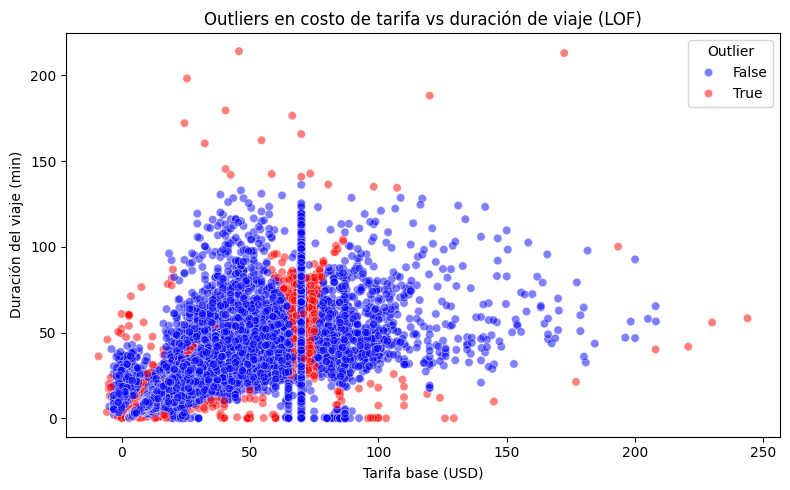

In [51]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='fare_amount',
    y='trip_duration',
    hue='lof_outlier_fare_dur',
    palette={True: 'red', False: 'blue'},
    alpha=0.5
)
plt.title('Outliers en costo de tarifa vs duración de viaje (LOF)')
plt.xlabel('Tarifa base (USD)')
plt.ylabel('Duración del viaje (min)')
plt.legend(title='Outlier')
plt.tight_layout()
plt.show()

Hay muchos registros con una tarifa estandar de aerpouerto, generamos un df auxiliar para analizar mejor sin estos registros

In [52]:
df_aux_wo_70 = df[(df['fare_amount'] != 70) & (df['RatecodeID'] != 'JFK')]

In [53]:
X = df_aux_wo_70[['fare_amount', 'trip_duration']]
X_scaled = StandardScaler().fit_transform(X)

In [54]:
lof = LocalOutlierFactor(n_neighbors=50)
df_aux_wo_70['lof_outlier_fare_dur'] = lof.fit_predict(X_scaled) == -1;

<ipython-input-54-b524ef327010>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



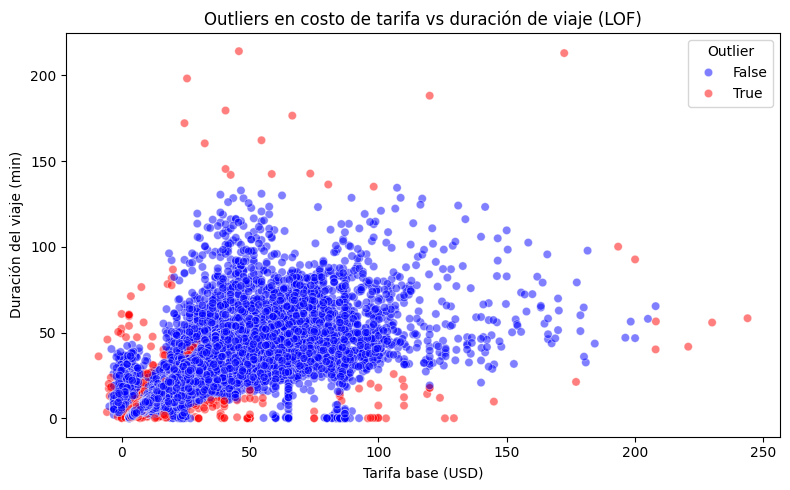

In [55]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_aux_wo_70,
    x='fare_amount',
    y='trip_duration',
    hue='lof_outlier_fare_dur',
    palette={True: 'red', False: 'blue'},
    alpha=0.5
);
plt.title('Outliers en costo de tarifa vs duración de viaje (LOF)')
plt.xlabel('Tarifa base (USD)')
plt.ylabel('Duración del viaje (min)')
plt.legend(title='Outlier')
plt.tight_layout()
plt.show();

Usamos el mismo df auxilar para analizar duración y distancia

In [56]:
X = df_aux_wo_70[['trip_duration', 'trip_distance']]
X_scaled = StandardScaler().fit_transform(X)

In [57]:
lof = LocalOutlierFactor(n_neighbors=50)
df_aux_wo_70['lof_outlier_dur_dist'] = lof.fit_predict(X_scaled) == -1;

<ipython-input-57-ab47570eabd7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



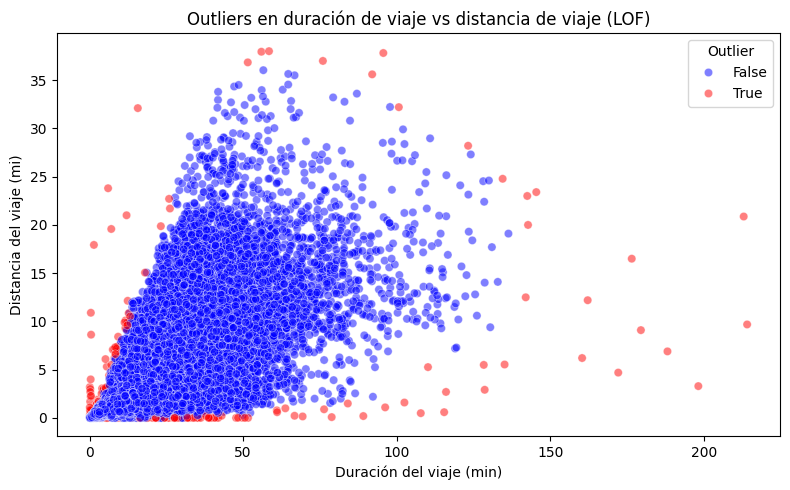

In [58]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_aux_wo_70,
    x='trip_duration',
    y='trip_distance',
    hue='lof_outlier_dur_dist',
    palette={True: 'red', False: 'blue'},
    alpha=0.5
);
plt.title('Outliers en duración de viaje vs distancia de viaje (LOF)')
plt.xlabel('Duración del viaje (min)')
plt.ylabel('Distancia del viaje (mi)')
plt.legend(title='Outlier')
plt.tight_layout()
plt.show();

Columna nueva con el porcentaje de propina respecto del costo de la tarifa

In [59]:
df['tip_pct'] = abs((df['tip_amount'] / (df['fare_amount'])) * 100)

Analizo el porcentaje respecto del costo

In [60]:
X = df[['fare_amount', 'tip_pct']]
X_scaled = StandardScaler().fit_transform(X)

In [61]:
iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['iso_outlier_tip'] = iso.fit_predict(X_scaled) == -1

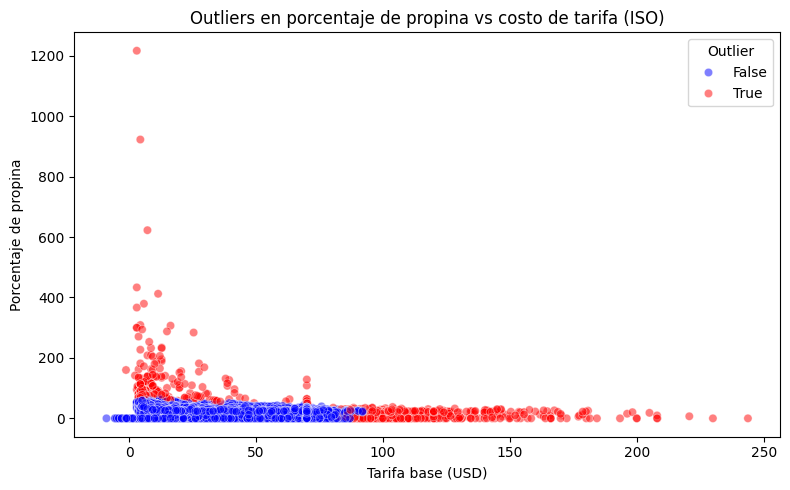

In [62]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='fare_amount',
    y='tip_pct',
    hue='iso_outlier_tip',
    palette={True: 'red', False: 'blue'},
    alpha=0.5
)
plt.title('Outliers en porcentaje de propina vs costo de tarifa (ISO)')
plt.xlabel('Tarifa base (USD)')
plt.ylabel('Porcentaje de propina')
plt.legend(title='Outlier')
plt.tight_layout()
plt.show()

Visualizamos algunos valores muy extremos y decidimos eliminarlos por la falta de sentido

In [63]:
df = df[df['tip_pct'] < 600]

# Nuevos Features

Ademas de las ya implementadas y utilizadas trip_duration y tip_pct

Sumatoria de los costos extras en una sola variable

In [64]:
df['total_extra_fees'] = (
    df['mta_tax'].fillna(0) +
    df['congestion_surcharge'].fillna(0) +
    df['Airport_fee'].fillna(0) +
    df['extra'].fillna(0)
)

Velocidad promedio de viaje

In [65]:
df['avg_speed_mph'] = df['trip_distance'] / (df['trip_duration'] / 60)

Costo por minuto

In [66]:
df['fare_per_min'] = df['fare_amount'] / df['trip_duration']

# Preguntas de Investigación

## ¿Cuáles son los lugares más frecuentes de inicio y fin de viaje?

In [67]:
zones.head()

LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone

Renombramos columnas

In [68]:
pickup_zones = zones.rename(columns={'LocationID': 'PULocationID', 'Zone': 'PickupZone'})
dropoff_zones = zones.rename(columns={'LocationID': 'DOLocationID', 'Zone': 'DropoffZone'})

Hacemos los joins

In [69]:
df = df.merge(pickup_zones[['PULocationID', 'PickupZone']], on='PULocationID', how='left')
df = df.merge(dropoff_zones[['DOLocationID', 'DropoffZone']], on='DOLocationID', how='left')

Buscamos las 10 zonas con mas frecuencia

In [70]:
top_pickup_zones = df['PickupZone'].value_counts().head(10)
top_dropoff_zones = df['DropoffZone'].value_counts().head(10)

print("Zonas más frecuentes de INICIO de viaje:")
print(top_pickup_zones)

print("\nZonas más frecuentes de FIN de viaje:")
print(top_dropoff_zones)

Zonas más frecuentes de INICIO de viaje:
PickupZone
Upper East Side South           5044
Midtown Center                  4414
JFK Airport                     4319
Upper East Side North           4221
Lincoln Square East             3268
Times Sq/Theatre District       3257
Penn Station/Madison Sq West    3243
Midtown East                    3242
LaGuardia Airport               2952
Midtown North                   2847
Name: count, dtype: int64

Zonas más frecuentes de FIN de viaje:
DropoffZone
Upper East Side North        4484
Upper East Side South        4382
Midtown Center               3651
Times Sq/Theatre District    2995
Murray Hill                  2798
Midtown East                 2795
Upper West Side South        2718
Lincoln Square East          2691
East Chelsea                 2561
Midtown North                2501
Name: count, dtype: int64


Visualizamos

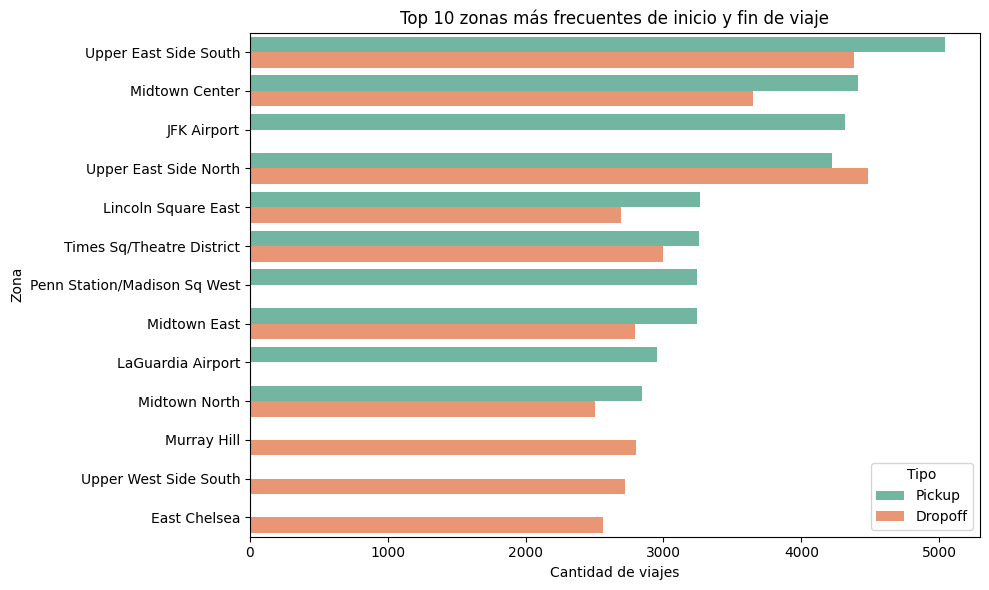

In [71]:
top_pickup = df['PickupZone'].value_counts().head(10).reset_index()
top_pickup.columns = ['Zone', 'Count']
top_pickup['Tipo'] = 'Pickup'

top_dropoff = df['DropoffZone'].value_counts().head(10).reset_index()
top_dropoff.columns = ['Zone', 'Count']
top_dropoff['Tipo'] = 'Dropoff'

zonas_top = pd.concat([top_pickup, top_dropoff], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=zonas_top, x='Count', y='Zone', hue='Tipo', palette='Set2')
plt.title("Top 10 zonas más frecuentes de inicio y fin de viaje")
plt.xlabel("Cantidad de viajes")
plt.ylabel("Zona")
plt.tight_layout()
plt.show()

## ¿Cómo son los viajes típicamente en distancia y duración?

Buscamos las estadísticas generales

In [72]:
print("Estadísticas de distancia:")
print(df['trip_distance'].describe())

print("\nEstadísticas de duración:")
print(df['trip_duration'].describe())

Estadísticas de distancia:
count    96276.000000
mean         3.373861
std          4.311592
min          0.010000
25%          1.040000
50%          1.770000
75%          3.380000
max         38.000000
Name: trip_distance, dtype: float64

Estadísticas de duración:
count    96276.000000
mean        17.800918
std         14.411192
min          0.033333
25%          8.300000
50%         13.816667
75%         22.533333
max        214.150000
Name: trip_duration, dtype: float64


Visualizamos en relación

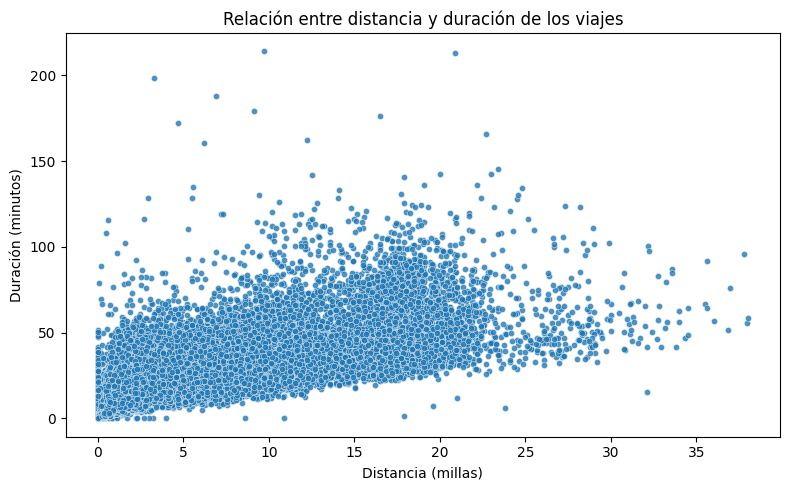

In [73]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='trip_distance', y='trip_duration', alpha=0.8, s=20)
plt.title("Relación entre distancia y duración de los viajes")
plt.xlabel("Distancia (millas)")
plt.ylabel("Duración (minutos)")

plt.tight_layout()
plt.show()

Visualizamos por separado

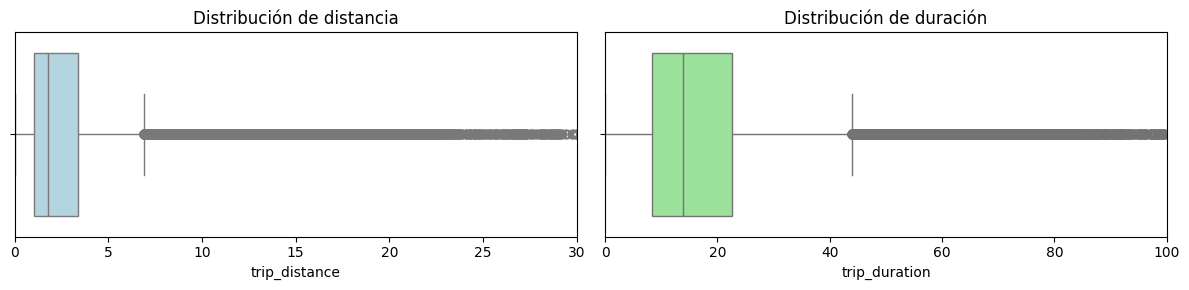

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
sns.boxplot(x=df['trip_distance'], ax=axes[0], color='lightblue')
axes[0].set_title("Distribución de distancia")
axes[0].set_xlim(0, 30)

sns.boxplot(x=df['trip_duration'], ax=axes[1], color='lightgreen')
axes[1].set_title("Distribución de duración")
axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.show()

## ¿Cómo varía la duración de los viajes según el día de la semana o la hora?

Creamos las columnas de hora y día

In [75]:
df['hour_of_day'] = df['tpep_pickup_datetime'].dt.hour
df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek  # 0 = lunes, 6 = domingo

days = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
df['day_of_week_label'] = df['day_of_week'].map(dict(enumerate(days)))

Agrupamos por hora y calculamos la duración promedio

In [76]:
df_hourly = df.groupby('hour_of_day')['trip_duration'].median().reset_index()

Visualizamos

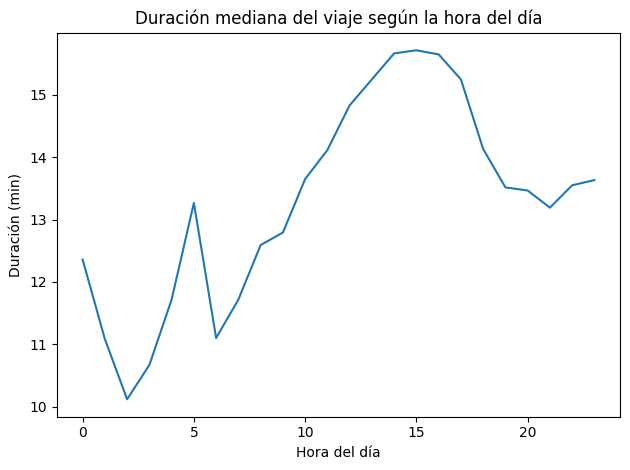

In [77]:
sns.lineplot(data=df_hourly, x='hour_of_day', y='trip_duration')
plt.title("Duración mediana del viaje según la hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Duración (min)")
plt.tight_layout()
plt.show()

Agrupamos por día y calculamos la duración promedio

In [78]:
df_dow = df.groupby('day_of_week_label')['trip_duration'].median().reset_index()

Visualizamos

<ipython-input-79-48e3226578a1>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




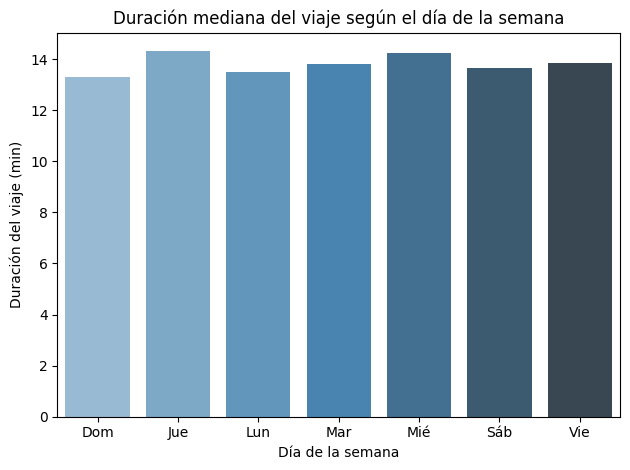

In [79]:
sns.barplot(data=df_dow, x='day_of_week_label', y='trip_duration', palette='Blues_d')
plt.title("Duración mediana del viaje según el día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Duración del viaje (min)")
plt.tight_layout()
plt.show()

Tabla de duración promedio por día y hora

In [80]:
heatmap_data = df.pivot_table(
    index='day_of_week',
    columns='hour_of_day',
    values='trip_duration',
    aggfunc='mean'
)

Visualizamos

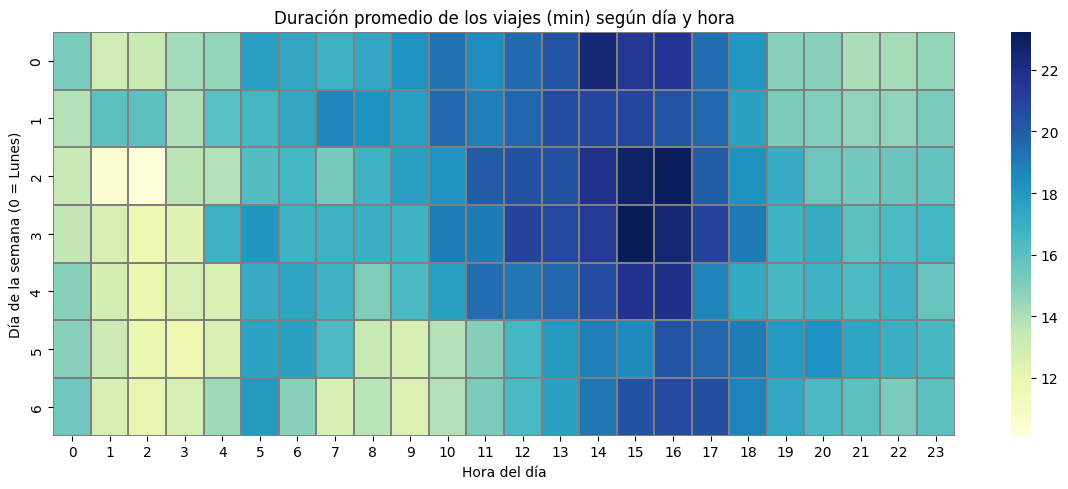

In [81]:
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.3, linecolor='gray')
plt.title("Duración promedio de los viajes (min) según día y hora")
plt.xlabel("Hora del día")
plt.ylabel("Día de la semana (0 = Lunes)")
plt.tight_layout()
plt.show()

## ¿Los viajes más largos tienen propinas más altas?

Creamos bins de duración para visualizar

In [82]:
df['duration_bin'] = pd.cut(df['trip_duration'], bins=[0, 5, 10, 15, 20, 30, 45, 60, 90, 120, np.inf])

Calculamos porcentaje de propina promedio por bin

In [83]:
grouped = df.groupby('duration_bin')['tip_pct'].mean().reset_index()

grouped['duration_bin'] = grouped['duration_bin'].astype(str)

<ipython-input-83-08b0174819c8>:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Visualizamos

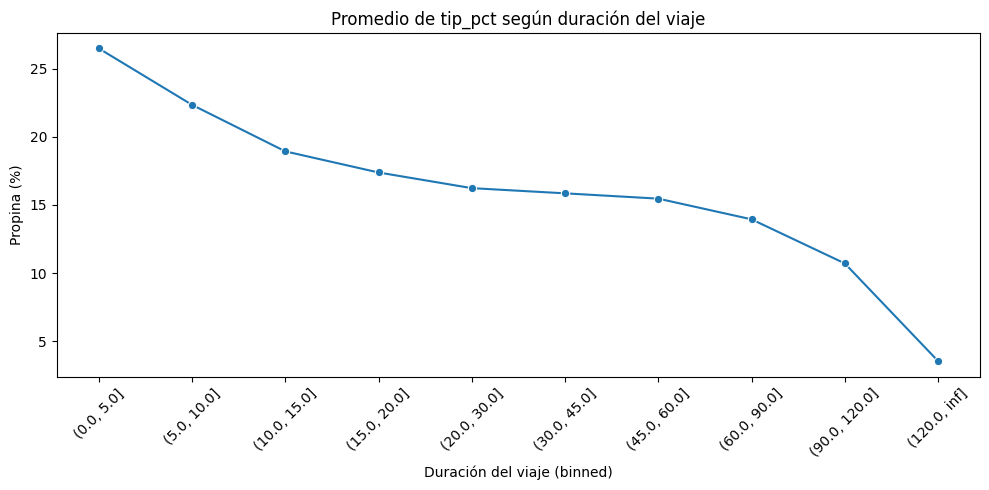

In [84]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=grouped, x='duration_bin', y='tip_pct', marker='o')
plt.title("Promedio de tip_pct según duración del viaje")
plt.xlabel("Duración del viaje (binned)")
plt.ylabel("Propina (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## ¿Qué proporción del monto total se destina a cargos extra en promedio?

Calculo el porcentaje de los costos extras

In [85]:
df['extra_pct'] = df['total_extra_fees'] / (df['total_amount']) * 100
df = df[(df['extra_pct'] > 0) & (df['extra_pct'] < 199)] # Pequeña limpieza elimina algunos outliers

Los imprimimos

In [86]:
print("Porcentaje de extras sobre el total:")
print(df['extra_pct'].describe(percentiles=[0.25, 0.5, 0.75, 0.95]))

Porcentaje de extras sobre el total:
count    95847.000000
mean        18.750885
std         11.761237
min          0.263241
25%         10.582011
50%         17.351070
75%         25.423729
95%         41.044776
max         84.210526
Name: extra_pct, dtype: float64


Visualizamos

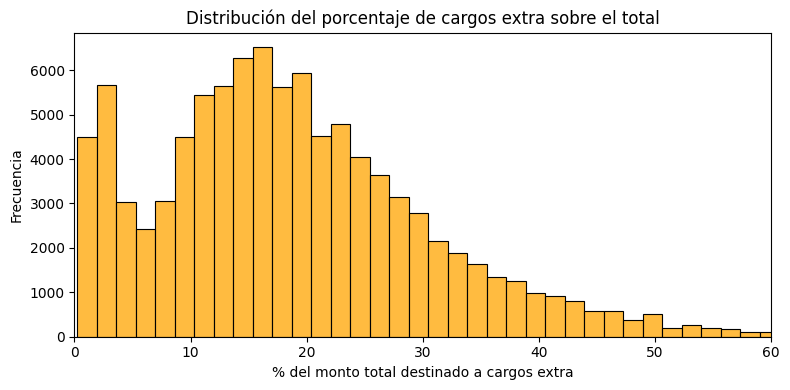

In [87]:
plt.figure(figsize=(8, 4))
sns.histplot(df['extra_pct'], bins=50, color='orange')
plt.title("Distribución del porcentaje de cargos extra sobre el total")
plt.xlabel("% del monto total destinado a cargos extra")
plt.ylabel("Frecuencia")
plt.xlim(0, 60)
plt.tight_layout()
plt.show()

## ¿Existen diferencias en las propinas según el método de pago?

In [88]:
df.groupby('payment_type')['tip_pct'].describe()

count       mean        std  min        25%   50%        75%  \
payment_type                                                                   
Disputa        1223.0   0.483223   3.113079  0.0   0.000000   0.0   0.000000   
Efectivo      13309.0   0.357785   2.892010  0.0   0.000000   0.0   0.000000   
Sin cargo       451.0   0.473586   3.071892  0.0   0.000000   0.0   0.000000   
Tarjeta       80864.0  22.819805  13.462875  0.0  15.555556  25.0  29.746835   

                     max  
payment_type              
Disputa        31.065089  
Efectivo       57.215190  
Sin cargo      26.606260  
Tarjeta       433.333333

<ipython-input-89-492e88ac63de>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




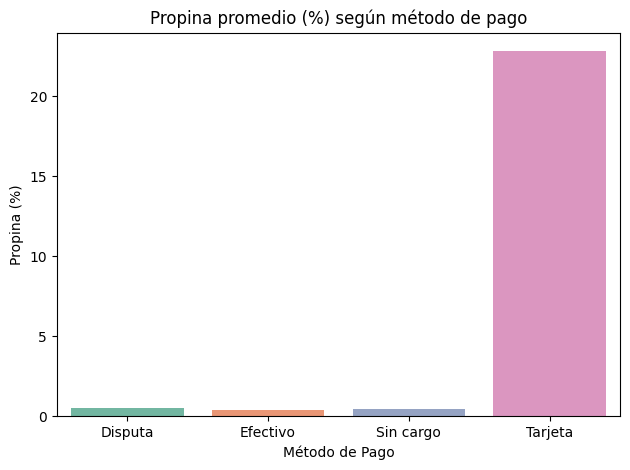

In [89]:
df_pay = df.groupby('payment_type')['tip_pct'].mean().reset_index()

sns.barplot(data=df_pay, x='payment_type', y='tip_pct', palette='Set2')
plt.title("Propina promedio (%) según método de pago")
plt.xlabel("Método de Pago")
plt.ylabel("Propina (%)")
plt.tight_layout()
plt.show()

## ¿Cómo varía la velocidad promedio de los viajes según la hora del día?

In [90]:
df_hourly_speed = df[df['avg_speed_mph'].notna()].groupby('hour_of_day')['avg_speed_mph'].mean().reset_index()

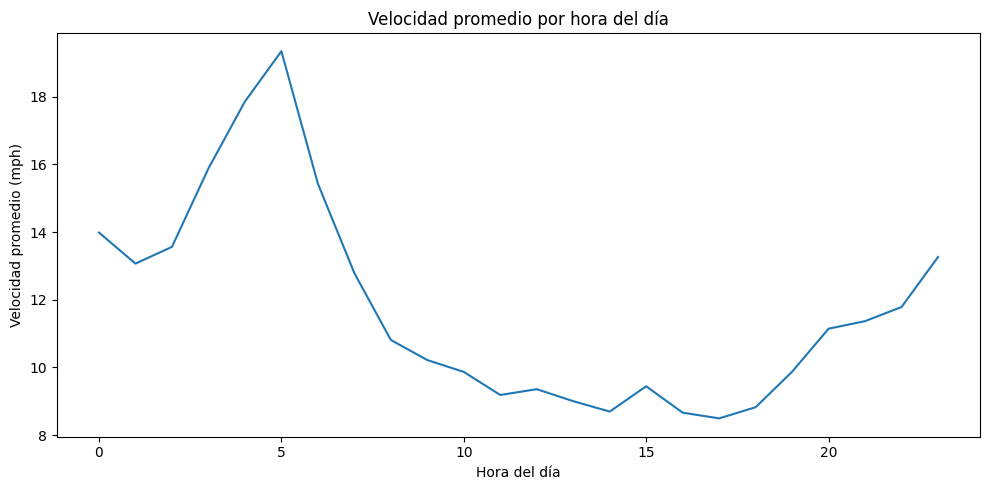

In [91]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_hourly_speed, x='hour_of_day', y='avg_speed_mph')
plt.title("Velocidad promedio por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Velocidad promedio (mph)")
plt.tight_layout()
plt.show()

## ¿Qué tan frecuente es el cobro del cargo de aeropuerto y en qué contextos se aplica?

In [92]:
print("Viajes con airport_fee > 0:")
print((df['Airport_fee'] > 0).sum())

print("\nProporción respecto al total:")
print(round((df['Airport_fee'] > 0).mean() * 100, 2), "%")

Viajes con airport_fee > 0:
7236

Proporción respecto al total:
7.55 %


In [93]:
df['Airport_fee'].value_counts()

Airport_fee
0.00    88611
1.75     7236
Name: count, dtype: int64

In [94]:
df_airport = df[df['Airport_fee'] > 0]

print("Promedio de distancia:", df_airport['trip_distance'].mean())
print("Promedio de duración:", df_airport['trip_duration'].mean())
print("Zona más frecuente de inicio:", df_airport['PickupZone'].value_counts().head(3))
print("Zona más frecuente de fin:", df_airport['DropoffZone'].value_counts().head(3))

Promedio de distancia: 13.104035378662243
Promedio de duración: 40.08704625023034
Zona más frecuente de inicio: PickupZone
JFK Airport          3995
LaGuardia Airport    2928
East Elmhurst         296
Name: count, dtype: int64
Zona más frecuente de fin: DropoffZone
Times Sq/Theatre District    442
Midtown Center               231
Midtown South                226
Name: count, dtype: int64


<ipython-input-95-0bc99512a181>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




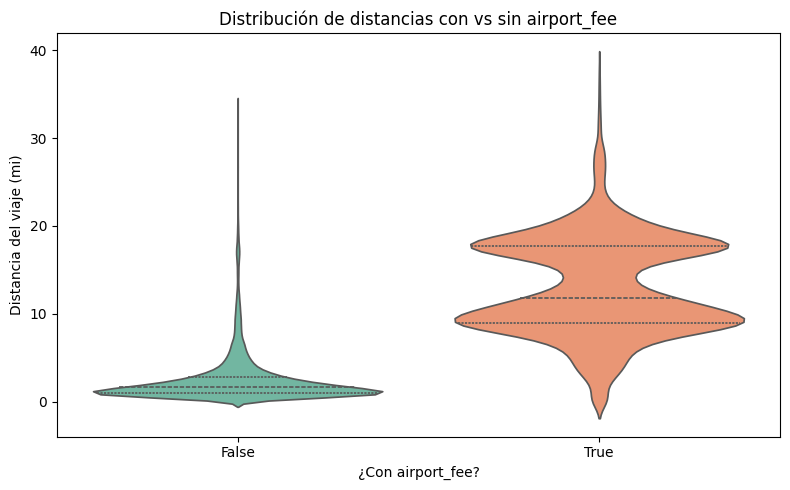

In [95]:
df['has_airport_fee'] = df['Airport_fee'] > 0

plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x='has_airport_fee', y='trip_distance', palette='Set2', inner='quartile')
plt.title("Distribución de distancias con vs sin airport_fee")
plt.xlabel("¿Con airport_fee?")
plt.ylabel("Distancia del viaje (mi)")
plt.tight_layout()
plt.show()

# Visualizaciones

¿Los viajes con más pasajeros son más caros? ¿O se mantienen similares?

<ipython-input-96-966f4c53e174>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




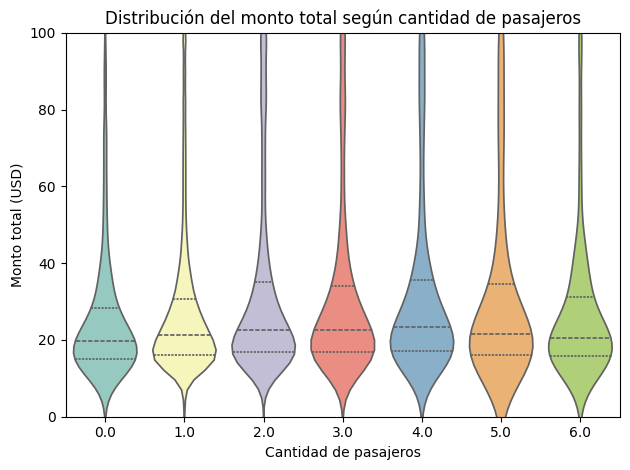

In [96]:
sns.violinplot(data=df, x='passenger_count', y='total_amount', inner='quartile', palette='Set3')
plt.title("Distribución del monto total según cantidad de pasajeros")
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Monto total (USD)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

¿Las tarifas planas duran más tiempo?

<ipython-input-97-aa78dc25f79f>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




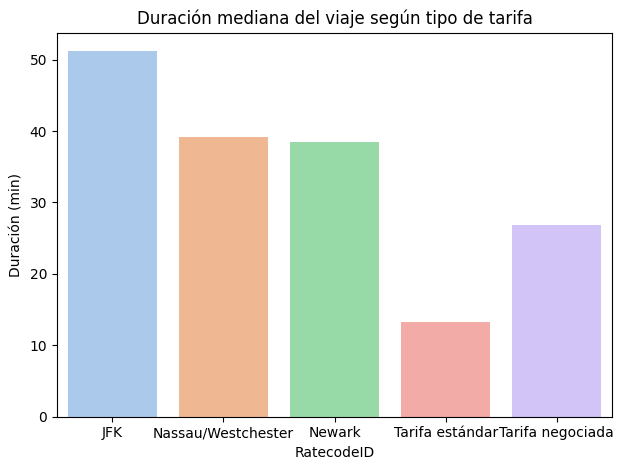

In [97]:
df_grouped = df.groupby('RatecodeID')['trip_duration'].median().reset_index()

sns.barplot(data=df_grouped, x='RatecodeID', y='trip_duration', palette='pastel')
plt.title("Duración mediana del viaje según tipo de tarifa")
plt.xlabel("RatecodeID")
plt.ylabel("Duración (min)")
plt.tight_layout()
plt.show()

¿En qué horarios se aplican más cargos extra?

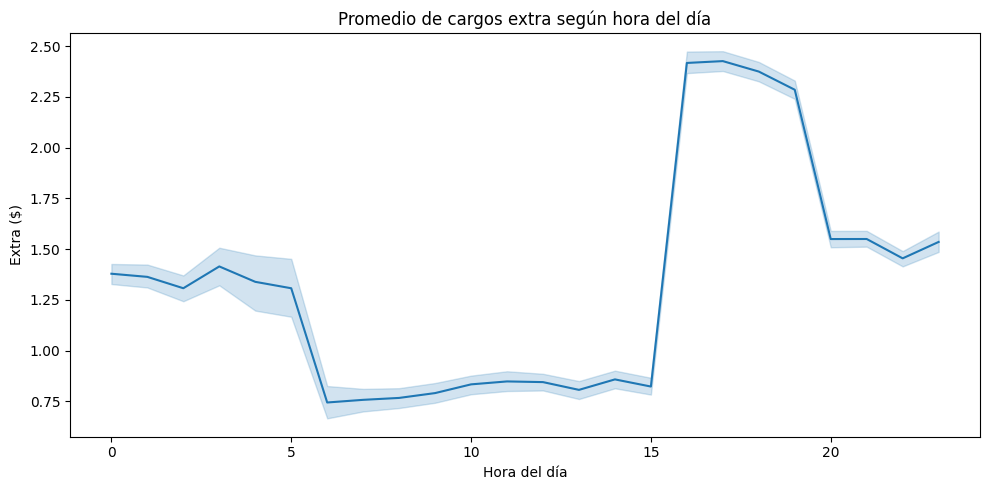

In [98]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='hour_of_day', y='extra')
plt.title("Promedio de cargos extra según hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Extra ($)")
plt.tight_layout()
plt.show()

Visualización por boroughs

<ipython-input-99-ed48e07ab236>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




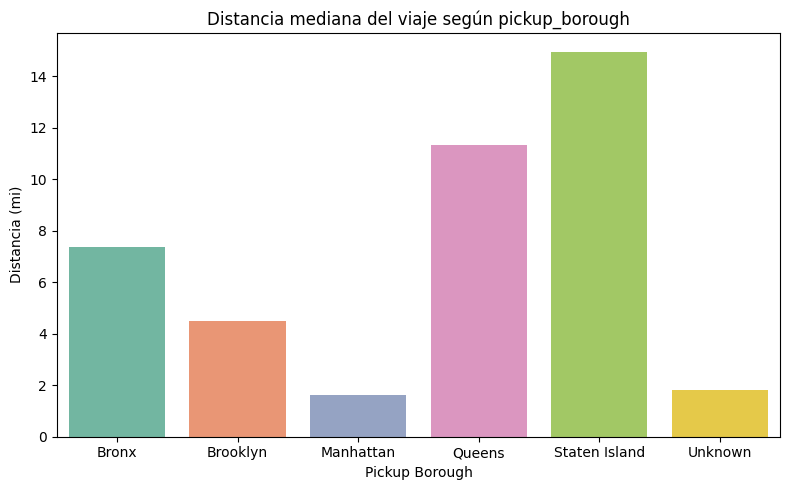

In [99]:
pickup_borough = zones[['LocationID', 'Borough']].rename(
    columns={'LocationID': 'PULocationID', 'Borough': 'pickup_borough'}
)

# Rehacer el merge
df = df.drop(columns=[col for col in df.columns if col == 'pickup_borough'], errors='ignore')
df = df.merge(pickup_borough, on='PULocationID', how='left')

df_borough = df.groupby('pickup_borough', as_index=False)['trip_distance'].median()

plt.figure(figsize=(8, 5))
sns.barplot(data=df_borough, x='pickup_borough', y='trip_distance', palette='Set2')
plt.title("Distancia mediana del viaje según pickup_borough")
plt.xlabel("Pickup Borough")
plt.ylabel("Distancia (mi)")
plt.tight_layout()
plt.show()

¿Cuándo se aplica más el recargo por congestión?

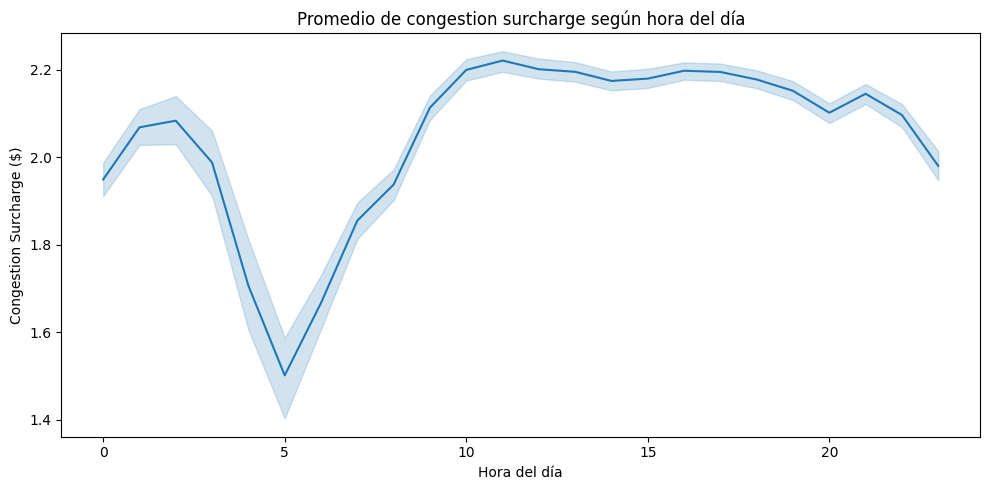

In [100]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df[df['congestion_surcharge'].notna()],
             x='hour_of_day', y='congestion_surcharge')
plt.title("Promedio de congestion surcharge según hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Congestion Surcharge ($)")
plt.tight_layout()
plt.show()

¿Se cobra más (en promedio) los fines de semana?

<ipython-input-101-7392bea358ae>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




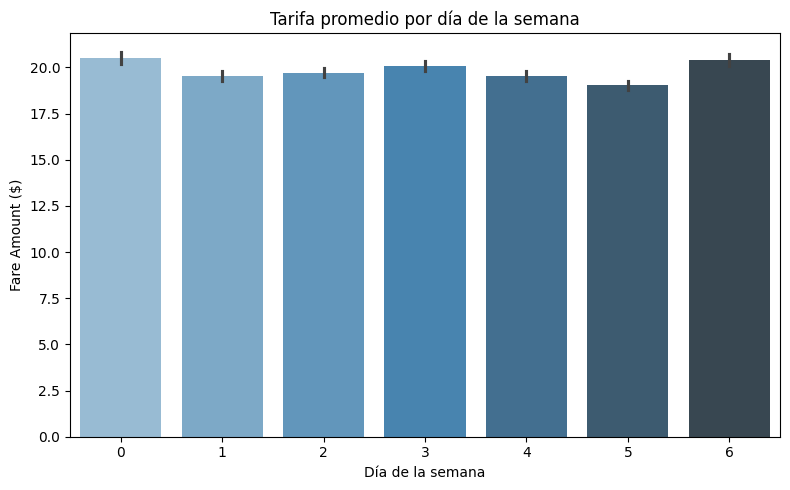

In [101]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='day_of_week', y='fare_amount', palette='Blues_d')
plt.title("Tarifa promedio por día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Fare Amount ($)")
plt.tight_layout()
plt.show()